## Very good paper about omics dimensionality reduction 
https://academic.oup.com/bib/article/17/4/628/2240645

In [126]:
import time
from collections import defaultdict
import json
import math

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['svg.fonttype'] = 'none'  # https://stackoverflow.com/questions/34387893/output-matplotlib-figure-to-svg-with-text-as-text-not-curves
plt.style.use('seaborn-ticks')

import seaborn as sns
import dateutil
from scipy.stats import spearmanr, pearsonr, kendalltau
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import dendrogram, fcluster, fclusterdata

from sklearn.cross_decomposition import PLSRegression, CCA
from sklearn.cluster import AgglomerativeClustering, FeatureAgglomeration
from sklearn.datasets import make_regression, make_classification
from sklearn.model_selection import (
    cross_val_score, cross_val_predict,
    RepeatedKFold, RepeatedStratifiedKFold,
    train_test_split, 
    GridSearchCV,
    LeaveOneGroupOut,
)
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance
from sklearn.metrics import (
    classification_report,
    roc_auc_score, roc_curve, RocCurveDisplay, auc,
    confusion_matrix, multilabel_confusion_matrix, ConfusionMatrixDisplay,
    f1_score, 
    recall_score,
    accuracy_score,
    precision_score, precision_recall_curve, precision_recall_fscore_support,
    explained_variance_score,
    #     plot_roc_curve,
    #     plot_precision_recall_curve,  ## The plot_x_score API is deprecated
)
import sklearn
print(sklearn.__version__)

1.0.2


In [224]:
# colors and class-superclass maps
with open(r'..\data\metadata\color_schemes.json') as infile:
    colors = json.load(infile)
lipid_superclasses = ['Phospholipid', 'Glycerolipid', 'Sphingolipid', 'Fatty Acyl', 'Sterol Lipid', 'Unidentified']
    
    
animals_used = [1091, 1093, 1060, 1062, 1074, 1092, 1102, 1076, 1082, 1101]
diabetic =     [1076, 1082, 1101]
impaired =     [1060, 1062, 1074, 1092, 1102]
normal =       [1091, 1093]
animal_tol = {
    1076: 'diabetic', 1082: 'diabetic', 1101: 'diabetic', 1060: 'impaired', 1062: 'impaired', 
    1074: 'impaired', 1092: 'impaired', 1102: 'impaired', 1091: 'normal', 1093: 'normal'}
ap = pd.read_excel(r'..\data\metadata\animal_phenotypes.xlsx', index_col=0)

fg = pd.read_csv(r'..\data\metadata\combined_metab_lipid_file_grouping.csv', index_col=0)

# Use data that was sent to collaborators 
data = pd.read_excel(r'../data/processed/combined_metabolites_data.xlsx').set_index('i')
data_cols = data.filter(regex='FBG|RBG').columns
fbg_cols = data.filter(regex='FBG').columns
rbg_cols = data.filter(regex='RBG').columns

In [225]:
# X_all = pd.DataFrame(StandardScaler().fit_transform(data[data_cols].T), index=data_cols, columns=data.index)

X_all = data[data_cols].T

y_3class = fg['gluc_tol']                                                 # ['normal', 'impaired', 'diabetic']
y_3class_num = y_3class.map({'normal': 0, 'impaired': 1, 'diabetic': 2})  # [0, 1, 2]
y_bg = fg['bg']                                                           # random/fasted blood glucoose
y_ogtt = fg['animal'].map(ap['OGTT (AUC)'])
y_weight = fg['animal'].map(ap['Weightprefastweek12'])
y_insulin = fg['animal'].map(ap['Insulin (AUC)'])

# PLS Regression is supervised regression. PLS-DA is the extension into classification

## Good examples
https://scikit-learn.org/stable/auto_examples/cross_decomposition/plot_pcr_vs_pls.html#sphx-glr-auto-examples-cross-decomposition-plot-pcr-vs-pls-py
https://scikit-learn.org/stable/auto_examples/cross_decomposition/plot_compare_cross_decomposition.html#sphx-glr-auto-examples-cross-decomposition-plot-compare-cross-decomposition-py

# In general, you do not need to center or standardize X for multiple regression: 
https://stats.stackexchange.com/questions/29781/when-conducting-multiple-regression-when-should-you-center-your-predictor-varia

## The results from PCA and CCA are identical regardless of StandardScale or not


In [18]:
data[data.columns.insert('molec_class')]

TypeError: insert() missing 1 required positional argument: 'item'

In [227]:
plsr = PLSRegression(n_components=2, max_iter=1000).fit(X_all, y_ogtt)
plsr.x_scores_[:, 0]
plsr

PLSRegression(max_iter=1000)

In [62]:
y_ogtt

combined_col_name
1091_8_FBG     19060.0
1091_9_FBG     19060.0
1091_10_FBG    19060.0
1093_8_FBG     25057.5
1093_9_FBG     25057.5
1093_10_FBG    25057.5
1060_8_FBG     48742.5
1060_9_FBG     48742.5
1060_10_FBG    48742.5
1062_8_FBG     43717.5
1062_9_FBG     43717.5
1062_10_FBG    43717.5
1074_8_FBG     35250.0
1074_9_FBG     35250.0
1074_10_FBG    35250.0
1092_8_FBG     34022.5
1092_9_FBG     34022.5
1092_10_FBG    34022.5
1102_8_FBG     46565.0
1102_9_FBG     46565.0
1102_10_FBG    46565.0
1076_8_FBG     60245.0
1076_9_FBG     60245.0
1076_10_FBG    60245.0
1082_8_FBG     56462.5
1082_9_FBG     56462.5
1082_10_FBG    56462.5
1101_8_FBG     55007.5
1101_9_FBG     55007.5
1101_10_FBG    55007.5
1091_8_RBG     19060.0
1091_9_RBG     19060.0
1091_10_RBG    19060.0
1093_8_RBG     25057.5
1093_9_RBG     25057.5
1093_10_RBG    25057.5
1060_8_RBG     48742.5
1060_9_RBG     48742.5
1060_10_RBG    48742.5
1062_8_RBG     43717.5
1062_9_RBG     43717.5
1062_10_RBG    43717.5
1074_8_RBG     3

In [127]:
explained_variance_score()

TypeError: explained_variance_score() missing 1 required positional argument: 'y_pred'

In [215]:
df

,coef,superclass,dummy
i,,,
l_5,-40.368199,Phospholipid,0
l_6,-1.879568,Phospholipid,0
l_7,-32.363890,Phospholipid,0
l_9,-9.074970,Phospholipid,0
l_10,-23.177397,Phospholipid,0
...,...,...,...
l_861,-33.173765,Glycerolipid,0
l_863,-37.672716,Glycerolipid,0
l_864,-29.510270,Glycerolipid,0


In [217]:
data['molec_C']

,unique_id,RT,m/z,adduct,Type,polarity,ID,1102_8_RBG,1093_9_RBG,1060_8_FBG,...,1102_9_RBG,1102_10_FBG,1102_10_RBG,molec_class,qval_sampling,qval_ogtt,qval_sampling:ogtt,pval_sampling,pval_ogtt,pval_sampling:ogtt
i,,,,,,,,,,,,,,,,,,,,,
m_0,unknown_2.353_141.06591,2.353,141.06591,[M-H]-1,metabolite,-,unknown,16.861652,16.671317,17.594730,...,18.479493,18.132105,16.858699,NaN,6.086023e-01,0.000230,0.631782,5.498881e-01,0.000028,0.520258
m_1,unknown_11.539_180.0585,11.539,180.05850,[M-H]-1,metabolite,-,unknown,22.144573,20.963399,20.198771,...,22.039171,20.757075,21.800102,NaN,2.768886e-10,0.002792,0.000126,6.116236e-11,0.000611,0.000003
m_2,Urocanic acid_11.365_139.05028,11.365,139.05028,[M+H]+1,metabolite,+,Urocanic acid,22.576981,23.843259,23.895235,...,23.627151,24.128623,20.875286,NaN,1.823227e-01,0.657168,0.685202,1.412000e-01,0.534845,0.582536
m_3,Uridine_7.513_243.06152,7.513,243.06152,[M-H]-1,metabolite,-,Uridine,23.803795,24.316310,24.714910,...,23.802189,24.693756,23.856317,NaN,1.263455e-10,0.085332,0.537969,2.563897e-11,0.040026,0.416631
m_4,Uric acid_12.732_167.02007,12.732,167.02007,[M-H]-1,metabolite,-,Uric acid,24.596731,26.201371,17.148994,...,27.789178,26.471452,25.842127,NaN,4.025503e-01,0.040372,0.259251,3.452344e-01,0.016251,0.151978
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
l_868,TG 18:0_18:0_18:0_19.885_908.86542,19.885,908.86542,NaN,lipid,+,TG 18:0_18:0_18:0,20.930734,20.351041,20.999142,...,21.260010,20.399305,20.648004,TG,1.446566e-02,0.003268,0.006008,8.989308e-03,0.000744,0.000817
l_869,unknown_20.144_948.89648,20.144,948.89648,NaN,lipid,+,unknown,19.535142,19.313450,19.774817,...,20.215013,18.965976,19.189126,unknown,7.182245e-02,0.400770,0.005990,5.036651e-02,0.275446,0.000805
l_870,unknown_20.148_897.82532,20.148,897.82532,NaN,lipid,+,unknown,18.104875,18.387917,20.517490,...,19.205373,20.095162,17.314487,unknown,1.166334e-08,0.278988,0.005976,3.220416e-09,0.174484,0.000793


In [228]:
def pls_reg(subset):
    plsr = PLSRegression(n_components=2, max_iter=1000).fit(X_all.loc[subset], y_ogtt.loc[subset])
    scores = pd.DataFrame(plsr.x_scores_, index=y_ogtt.loc[subset].index, columns=['scores1', 'scores2'])
    scores = scores.join(fg['gluc_tol'])
    df = pd.DataFrame(plsr.x_loadings_, index=data.index, columns=['loadings1', 'loadings2'])
#     df['scores1'] = plsr.x_scores_[:, 0]
#     df['scores2'] = plsr.x_scores_[:, 1]
    df['coef'] = plsr.coef_
    df = df.join(data[data.columns[0:11].to_list() + ['molec_class']])
    df = df.loc[(df['Type'] == 'lipid')]
#     display(df)
    df['superclass'] = df['molec_class'].apply(lambda x: colors[x]['superclass'], )
    return df, scores

d = {}
for subset, name in zip([data_cols, rbg_cols, fbg_cols], ['all', 'rbg', 'fbg']):   
    d[name], d[name + '_scores'] = pls_reg(subset)

## Plot coefficients from PLSR, colored by lipid superclass

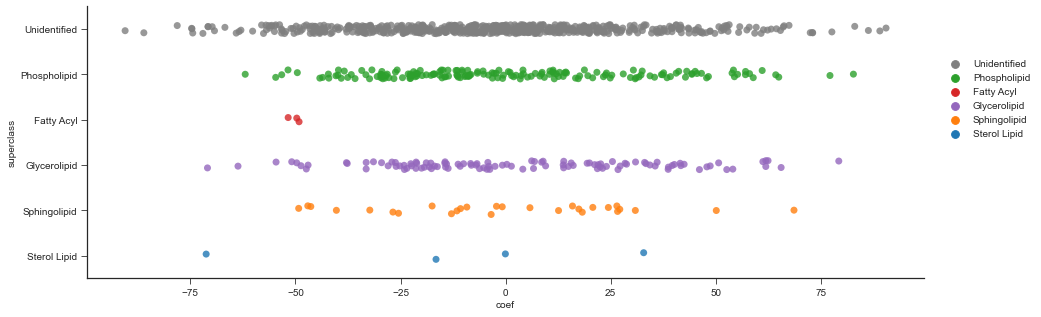

In [246]:
df = d['fbg'][['coef', 'superclass']].copy()
df['dummy'] = 0
df
fig, ax = plt.subplots(figsize=(15, 5))
sns.stripplot(
    data=df, x='coef', y='superclass', 
    orient='h', 
    s=7,
#     dodge=False,
    hue='superclass', palette=colors,
#     order=lipid_superclasses,
    alpha=0.8
)
plt.legend(loc=(1.02, 0.5))
sns.despine()

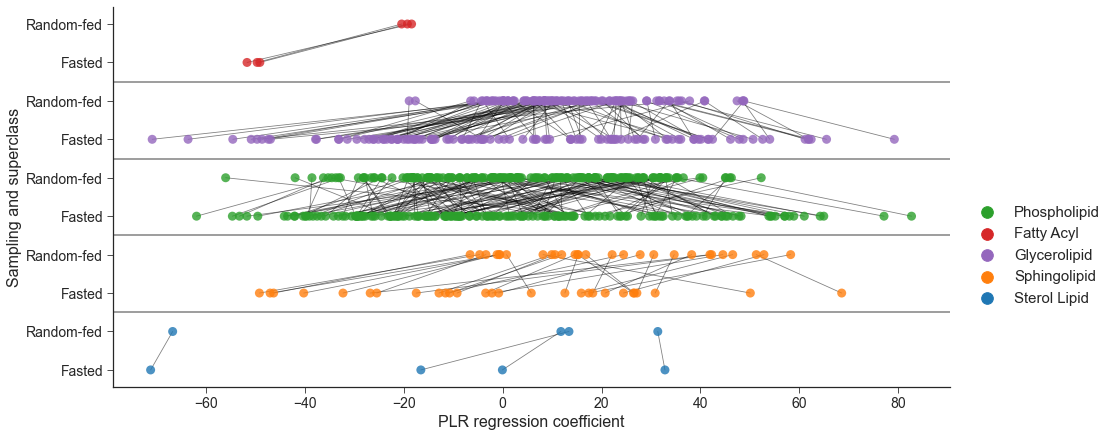

In [400]:
for lsc in lipid_superclasses:
    colors[lsc + '1'] = colors[lsc]
    colors[lsc + ' Fasted'] = colors[lsc]
    colors[lsc + ' Random-fed'] = colors[lsc]
df_rbg = d['rbg'][['coef', 'superclass']].copy()
df_fbg = d['fbg'][['coef', 'superclass']].copy()
# df_rbg['superclass'] = df_rbg['superclass'] + ' Random-fed'
# df_fbg['superclass'] = df_fbg['superclass'] + ' Fasted'
df_fbg['superclass'] = df_fbg['superclass'] + '1'

y_index_map = {lsc: x for lsc, x in zip(sorted(df_all['superclass'].unique()), range(len(df_all['superclass'].unique())))}
df_rbg['y_index'] = df_rbg['superclass'].map(y_index_map)
df_fbg['y_index'] = df_fbg['superclass'].map(y_index_map)

df_all = df_rbg.append(df_fbg)
df_all['y_index'] = df['superclass'].map(y_index_map)
# df = df.append(d['fbg'][['coef', 'superclass']])

fig, ax = plt.subplots(figsize=(15, 7))

sns.stripplot(
    data=df_all.loc[~df_all['superclass'].str.contains('Unidentified')], x='coef', y='superclass', 
    orient='h', jitter=0, marker='o', s=9, alpha=0.8,
    hue='superclass', palette=colors,  # edgecolor='gray', linewidth=1, 
    ax=ax, order=sorted(df_all['superclass'].unique())[:-2],
)

# sns.catplot(
#     data=df_all.loc[~df_all['superclass'].str.contains('Unidentified')], x='coef', y='superclass', 
#     orient='h', jitter=0, marker='o', s=9, alpha=0.8,
#     hue='superclass', palette=colors, 
# #     edgecolor='gray', linewidth=1, 
# #     ax=ax, 
#     legend=False,
#     order=sorted(df['superclass'].unique())[:-2],
# )
# plt.gcf().set_size_inches(15, 6)

for (i, rowr), (j, rowf) in zip(df_rbg.iterrows(), df_fbg.iterrows()):
    if rowr['superclass'] == 'Unidentified':
        continue
#     if abs(rowr['coef']) > abs(rowf['coef']): 
#         color = 'darkred'
#     else: 
#         color='blue'
    plt.plot([rowr['coef'], rowf['coef']], [rowr['y_index'], rowf['y_index']], 
#              c=colors[rowr['superclass']], 
             c='black', #linestyle=linestyle,
             alpha=0.5, linewidth=0.8,)
    
plt.xlabel('PLR regression coefficient', fontsize=16)
plt.xticks(fontsize=14)
plt.ylabel('Sampling and superclass', fontsize=16)
plt.yticks(ticks=plt.yticks()[0], labels=['Random-fed', 'Fasted'] * 5, fontsize=14)
for y in np.arange(1.5, 8.5, 2):
    plt.axhline(y=y, c='gray', )
# plt.grid(which='major', axis='y', c='black')

handles, labels = ax.get_legend_handles_labels()
plt.legend(handles=handles[:5], labels=labels[:5], loc=(1.02, 0.2), markerscale=1.5, fontsize=15)
sns.despine()

plt.savefig(r'..\reports\figures\3-5-1\pls_R_vs_F_feature_coef.png', dpi=150, bbox_inches='tight')
plt.savefig(r'..\reports\figures\3-5-1\pls_R_vs_F_feature_coef.svg', dpi=150, bbox_inches='tight')

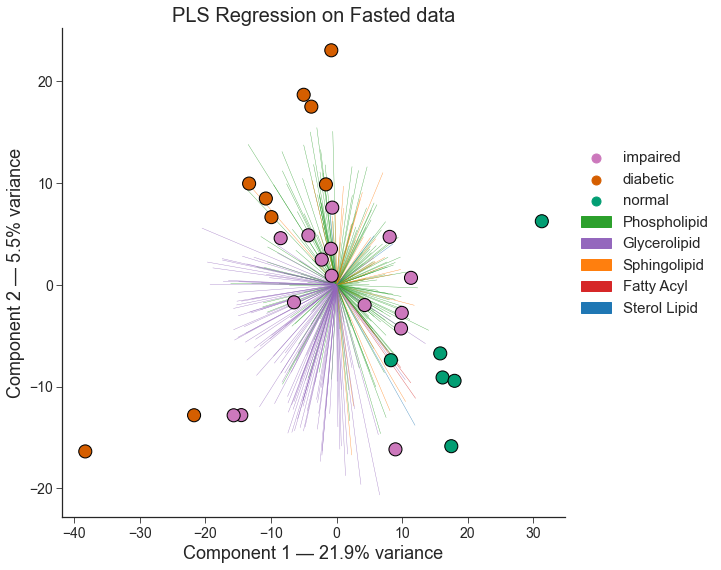

In [401]:
def make_biplot(subset, subset_cols):
    fig, ax = plt.subplots(figsize=(9, 9))
    for i, (index, row) in enumerate(d[subset].iterrows()):
        if row['ID'] == 'unknown':
            continue
        l1 = row['loadings1'] * 350
        l2 = row['loadings2'] * 350
        c = colors[row['superclass']]
        ax.arrow(0, 0, l1, l2, color=c, linewidth=0.4, alpha=0.4)
    scores = d[subset + '_scores']
    sns.scatterplot(
        data=scores, x='scores1', y='scores2',
        hue='gluc_tol', palette=colors,
        s=170, ax=ax, edgecolor='black')
    
    # https://stackoverflow.com/questions/46327928/sklearn-plsregression-variance-of-x-explained-by-latent-vectors
    total_X_var = np.var(X_all.loc[subset_cols], axis=0).sum()
    component_var = np.var(plsr.x_scores_, axis=0) / total_X_var
    plt.xlabel(f'Component 1 — {round(component_var[0]*100, 1)}% variance', fontsize=18)
    plt.ylabel(f'Component 2 — {round(component_var[1]*100, 1)}% variance', fontsize=18)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    
    # Make a few invisible dummy arrows to generate a legend
    
    for lsc in lipid_superclasses:
        ax.arrow(0, 0, 0, 0, color=colors[lsc], label=lsc)
    handles, labels = ax.get_legend_handles_labels()
    plt.legend(handles=handles[:-1], labels=labels[:-1], loc=(1.02, 0.4), markerscale=1.5, fontsize=15)
    sns.despine()
    
    
make_biplot('fbg', fbg_cols)
plt.title('PLS Regression on Fasted data', fontsize=20)

plt.savefig(r'..\reports\figures\3-5-1\fasted_biplot.png', dpi=150, bbox_inches='tight')
plt.savefig(r'..\reports\figures\3-5-1\fasted_biplot.svg', dpi=150, bbox_inches='tight')

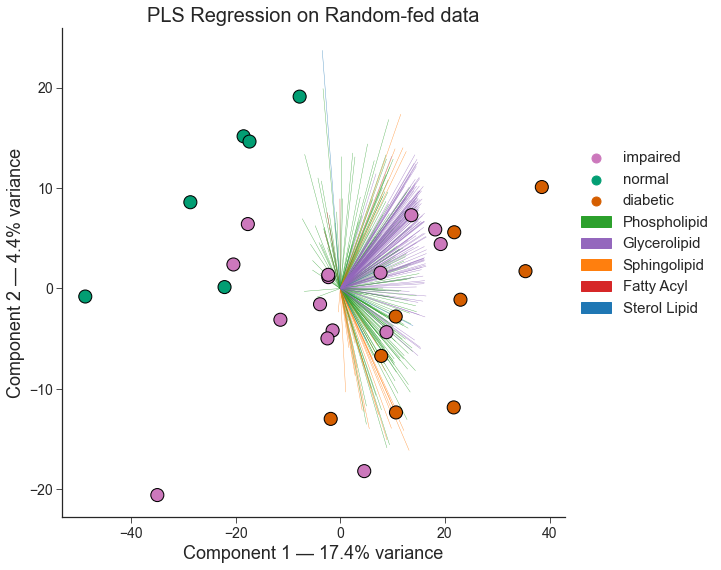

In [402]:
make_biplot('rbg', rbg_cols)
plt.title('PLS Regression on Random-fed data', fontsize=20)

plt.savefig(r'..\reports\figures\3-5-1\fed_biplot.png', dpi=150, bbox_inches='tight')
plt.savefig(r'..\reports\figures\3-5-1\fed_biplot.svg', dpi=150, bbox_inches='tight')

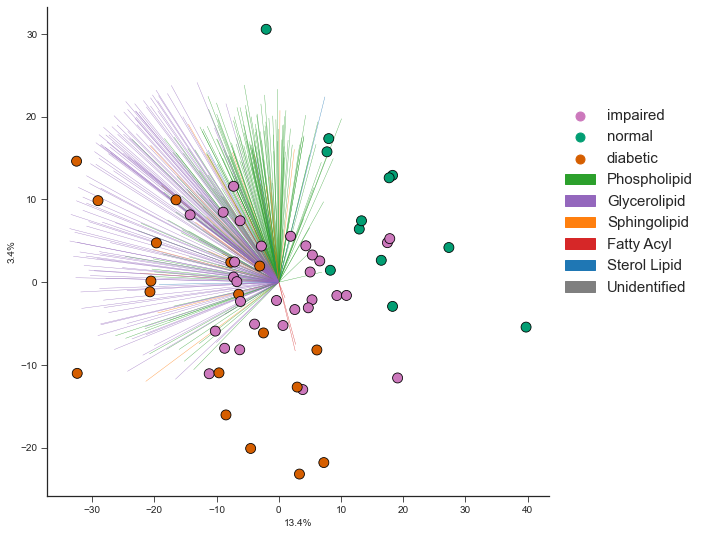

In [233]:
make_biplot('all', data_cols)

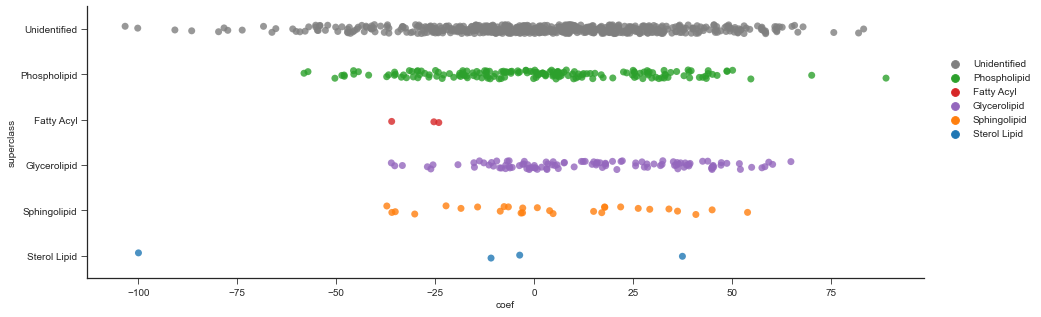

In [248]:
df = d['all'][['coef', 'superclass']].copy()
df['dummy'] = 0
df
fig, ax = plt.subplots(figsize=(15, 5))
sns.stripplot(
    data=df, x='coef', y='superclass', 
    orient='h', 
    s=7,
#     dodge=False,
    hue='superclass', palette=colors,
#     order=lipid_superclasses,
    alpha=0.8
)
plt.legend(loc=(1.02, 0.5))
sns.despine()

C:\Users\bjanderson23\anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='0', ylabel='0'>

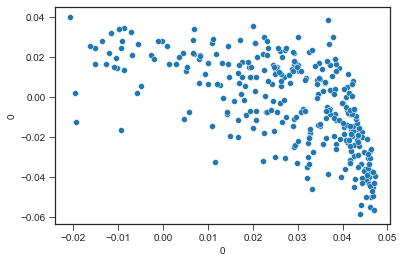

In [25]:
sns.scatterplot(d['rbg'][0], d['fbg'][0])

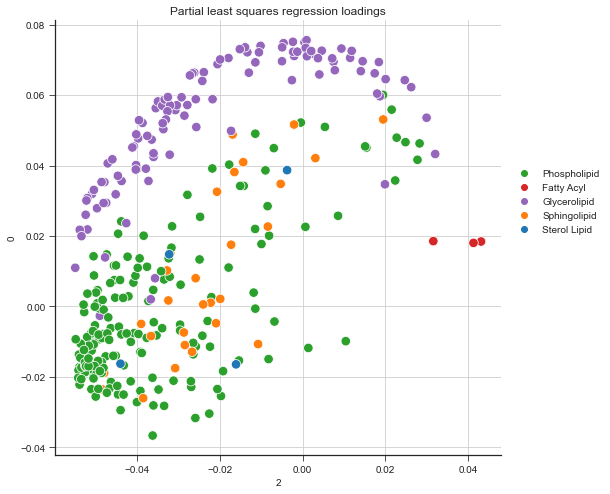

In [88]:
fig, ax = plt.subplots(figsize=(8,8))
plt.title('Partial least squares regression loadings')

sns.scatterplot(
    data=df, x=2, y=0, hue='superclass',
    s=90, 
    palette=colors
)
plt.grid()
plt.legend(loc=(1.02, 0.5))
sns.despine()

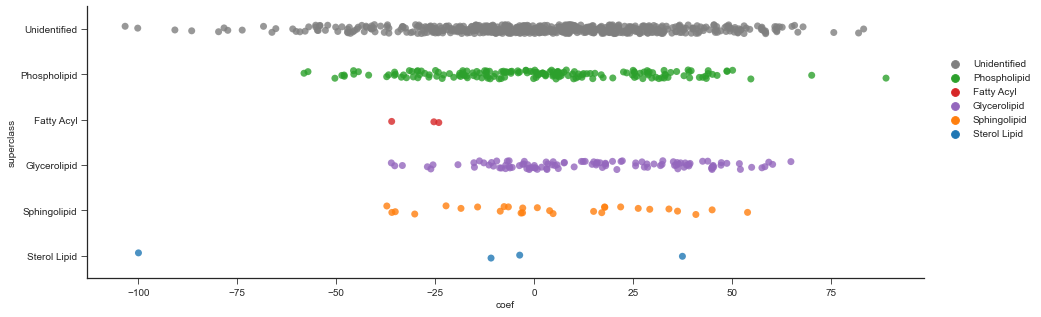

In [248]:
df = d['all'][['coef', 'superclass']].copy()
df['dummy'] = 0
df
fig, ax = plt.subplots(figsize=(15, 5))
sns.stripplot(
    data=df, x='coef', y='superclass', 
    orient='h', 
    s=7,
#     dodge=False,
    hue='superclass', palette=colors,
#     order=lipid_superclasses,
    alpha=0.8
)
plt.legend(loc=(1.02, 0.5))
sns.despine()

In [207]:
df

,coef,superclass,dummy
i,,,
l_5,-40.368199,Phospholipid,0
l_6,-1.879568,Phospholipid,0
l_7,-32.363890,Phospholipid,0
l_9,-9.074970,Phospholipid,0
l_10,-23.177397,Phospholipid,0
...,...,...,...
l_861,-33.173765,Glycerolipid,0
l_863,-37.672716,Glycerolipid,0
l_864,-29.510270,Glycerolipid,0


In [95]:
d['fbg']

,loadings1,loadings2,coef,unique_id,RT,m/z,adduct,Type,polarity,ID,1102_8_RBG,1093_9_RBG,1060_8_FBG,1060_8_RBG,molec_class,superclass
i,,,,,,,,,,,,,,,,
l_5,0.031911,-0.009666,-40.368199,LysoPC 20:5_1.036_542.32452,1.036,542.32452,NaN,lipid,+,LysoPC 20:5,25.647760,26.973065,23.835084,26.317480,LysoPC,Phospholipid
l_6,0.001986,-0.004779,-1.879568,LysoPC 16:0_1.095_496.33994,1.095,496.33994,NaN,lipid,+,LysoPC 16:0,26.922772,28.708609,26.253075,28.431526,LysoPC,Phospholipid
l_7,0.014487,-0.024271,-32.363890,LysoPC 18:1_1.137_522.35236,1.137,522.35236,NaN,lipid,+,LysoPC 18:1,23.033801,23.842277,21.278809,23.457071,LysoPC,Phospholipid
l_9,0.015213,-0.002117,-9.074970,LysoPC 22:6_1.289_568.33972,1.289,568.33972,NaN,lipid,+,LysoPC 22:6,24.169049,25.812168,25.394377,26.096576,LysoPC,Phospholipid
l_10,0.024605,-0.002600,-23.177397,LysoPC 15:0_1.324_482.32388,1.324,482.32388,NaN,lipid,+,LysoPC 15:0,20.923253,22.214125,20.671309,21.992457,LysoPC,Phospholipid
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
l_861,-0.007138,-0.049565,-33.173765,TG 57:2_19.582_946.88043,19.582,946.88043,NaN,lipid,+,TG 57:2,19.849247,19.422779,20.153422,18.842131,TG,Glycerolipid
l_863,0.002048,-0.045222,-37.672716,TG 56:1_19.841_934.88123,19.841,934.88123,NaN,lipid,+,TG 56:1,21.470210,20.888517,20.975758,20.602708,TG,Glycerolipid
l_864,0.000574,-0.039832,-29.510270,TG 18:2_18:1_24:0_19.865_986.91193,19.865,986.91193,NaN,lipid,+,TG 18:2_18:1_24:0,20.600064,19.856448,19.408564,19.499073,TG,Glycerolipid


In [97]:
d['fbg']

,loadings1,loadings2,coef,unique_id,RT,m/z,adduct,Type,polarity,ID,1102_8_RBG,1093_9_RBG,1060_8_FBG,1060_8_RBG,molec_class,superclass
i,,,,,,,,,,,,,,,,
l_5,0.031911,-0.009666,-40.368199,LysoPC 20:5_1.036_542.32452,1.036,542.32452,NaN,lipid,+,LysoPC 20:5,25.647760,26.973065,23.835084,26.317480,LysoPC,Phospholipid
l_6,0.001986,-0.004779,-1.879568,LysoPC 16:0_1.095_496.33994,1.095,496.33994,NaN,lipid,+,LysoPC 16:0,26.922772,28.708609,26.253075,28.431526,LysoPC,Phospholipid
l_7,0.014487,-0.024271,-32.363890,LysoPC 18:1_1.137_522.35236,1.137,522.35236,NaN,lipid,+,LysoPC 18:1,23.033801,23.842277,21.278809,23.457071,LysoPC,Phospholipid
l_9,0.015213,-0.002117,-9.074970,LysoPC 22:6_1.289_568.33972,1.289,568.33972,NaN,lipid,+,LysoPC 22:6,24.169049,25.812168,25.394377,26.096576,LysoPC,Phospholipid
l_10,0.024605,-0.002600,-23.177397,LysoPC 15:0_1.324_482.32388,1.324,482.32388,NaN,lipid,+,LysoPC 15:0,20.923253,22.214125,20.671309,21.992457,LysoPC,Phospholipid
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
l_861,-0.007138,-0.049565,-33.173765,TG 57:2_19.582_946.88043,19.582,946.88043,NaN,lipid,+,TG 57:2,19.849247,19.422779,20.153422,18.842131,TG,Glycerolipid
l_863,0.002048,-0.045222,-37.672716,TG 56:1_19.841_934.88123,19.841,934.88123,NaN,lipid,+,TG 56:1,21.470210,20.888517,20.975758,20.602708,TG,Glycerolipid
l_864,0.000574,-0.039832,-29.510270,TG 18:2_18:1_24:0_19.865_986.91193,19.865,986.91193,NaN,lipid,+,TG 18:2_18:1_24:0,20.600064,19.856448,19.408564,19.499073,TG,Glycerolipid


In [138]:
ld = {}  # ld = LeaveOneGroupOut Dictionary

for columns, column_name in zip([rbg_cols, fbg_cols], ['RBG', 'FBG']):
    X = X_all.loc[columns]
    ld[column_name] = {}
    for y_data, y_name in (
        [y_ogtt, 'ogtt'], 
#         [y_weight, 'weight'], 
#         [y_insulin, 'insulin']
    ):
        y = y_data.loc[columns]
        ld[column_name][y_name] = {}
        
        for est, model_name in [(PLSRegression(n_components=1), 'pls'), (CCA(n_components=1), 'cca')]:
            d = ld[column_name][y_name][model_name] = {}
            d['feat_imp'] = 0
            d['y_true'] = []
            d['y_pred'] = []
            logo = LeaveOneGroupOut()
            for train, test in logo.split(X, y, groups=X.index.map(fg['animal'])):
                model = est.fit(X.iloc[train], y.iloc[train])
                y_pred = model.predict(X.iloc[test])
                d['feat_imp'] += model.coef_
                d['y_true'].extend(y.iloc[test])
                d['y_pred'].extend([val[0] for val in y_pred])

In [139]:
rp = ld['RBG']['ogtt']['pls']
fp = ld['FBG']['ogtt']['pls']
rc = ld['RBG']['ogtt']['cca']
fc = ld['FBG']['ogtt']['cca']

In [148]:
total_X_var = np.var(X_all, axis=0).sum()
component_var = np.var(plsr.x_scores_, axis=0)
component_var/total_X_var

array([0.13396023, 0.03387914])

Text(0.5, 1.0, 'Fasted PLS\nMean absolute percentage error: 20.0%')

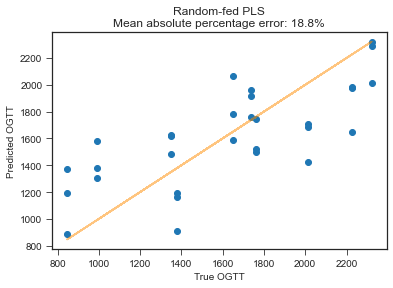

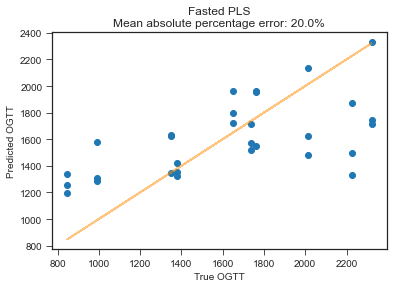

In [156]:
df = rp
y_true = np.array(df['y_true'])
y_pred = np.array(df['y_pred'])
resid = y_true - y_pred
plt.scatter(y_true, y_pred)
plt.plot(y_ogtt.loc[rbg_cols], y_ogtt.loc[rbg_cols], c='darkorange', alpha=0.5)
plt.xlabel('True OGTT')
plt.ylabel('Predicted OGTT')
mean_perc_error = round(abs(resid / y_true).mean(), 3) * 100
plt.title(f'Random-fed PLS\nMean absolute percentage error: {mean_perc_error}%')

plt.figure()

df = fp
y_true = np.array(df['y_true'])
y_pred = np.array(df['y_pred'])
resid = y_true - y_pred
plt.scatter(y_true, y_pred)
plt.plot(y_ogtt.loc[rbg_cols], y_ogtt.loc[rbg_cols], c='darkorange', alpha=0.5)
plt.xlabel('True OGTT')
plt.ylabel('Predicted OGTT')
mean_perc_error = round(abs(resid / y_true).mean(), 3) * 100
plt.title(f'Fasted PLS\nMean absolute percentage error: {mean_perc_error}%')

In [67]:
d['fbg_scores']

,scores1,scores2
1060_8_FBG,-14.518950,-12.788900
1060_9_FBG,-8.520310,4.601337
1060_10_FBG,-0.659540,7.603215
1062_8_FBG,-2.267650,2.495183
1062_9_FBG,-4.296004,4.882422
1062_10_FBG,-15.684612,-12.805898
1074_8_FBG,8.088870,4.728583
1074_9_FBG,4.279449,-1.972463
1074_10_FBG,9.933263,-2.739817
1076_8_FBG,-10.777320,8.499177


In [151]:
plscoef = pd.DataFrame({'RBGpls': rp['feat_imp'][:, 0], 'FBGpls': fp['feat_imp'][:, 0],})
plscoef

# plscoef.to_csv(r'..\models\feat_importances\pls_regression_feature_importances.csv')

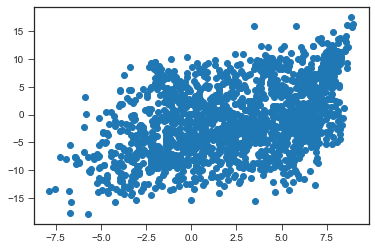

In [150]:
plt.scatter(plscoef['RBGpls'], plscoef['FBGpls'])

Text(0.5, 1.0, 'Distribution of coefficients for PLS Regression')

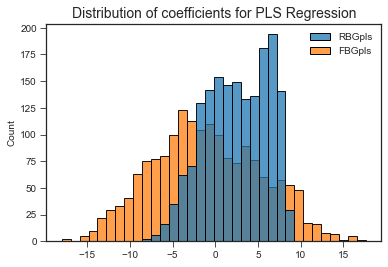

In [152]:
sns.histplot(plscoef)
plt.title('Distribution of coefficients for PLS Regression', fontsize=14)

### CCA is terrible. It predicts -7000 for some OGTT values

# regular CCA is limited to n > p, and does not do feature selection
### but other CCAs (sparse CCA, penalized CCA) can do feature selection 
https://academic.oup.com/bib/article/17/4/628/2240645


In [159]:
# df = rc
# y_true = np.array(df['y_true'])
# y_pred = np.array(df['y_pred'])
# resid = y_true - y_pred
# plt.scatter(y_true, y_pred)
# plt.plot(y_ogtt.loc[rbg_cols], y_ogtt.loc[rbg_cols], c='darkorange', alpha=0.5)
# plt.xlabel('True OGTT')
# plt.ylabel('Predicted OGTT')
# mean_perc_error = round(abs(resid / y_true).mean(), 3) * 100
# plt.title(f'Random-fed PLS\nMean absolute percentage error: {mean_perc_error}%')

# plt.figure()

# df = fc
# y_true = np.array(df['y_true'])
# y_pred = np.array(df['y_pred'])
# resid = y_true - y_pred
# plt.scatter(y_true, y_pred)
# plt.plot(y_ogtt.loc[rbg_cols], y_ogtt.loc[rbg_cols], c='darkorange', alpha=0.5)
# plt.xlabel('True OGTT')
# plt.ylabel('Predicted OGTT')
# mean_perc_error = round(abs(resid / y_true).mean(), 3) * 100
# plt.title(f'Random-fed PLS\nMean absolute percentage error: {mean_perc_error}%')

In [130]:
X_train, X_test, y_train, y_test = train_test_split(X_all, y_ogtt, test_size=0.1, random_state=1)

pls = PLSRegression(n_components=20).fit(X_all.loc[rbg_cols], y_ogtt.loc[rbg_cols])
cca = CCA(n_components=1).fit(X_all.loc[rbg_cols], y_ogtt.loc[rbg_cols])

pls.coef_
cca.coef_

array([[ 13.32249139],
       [ 10.49394781],
       [  2.23460843],
       ...,
       [-13.58078583],
       [ -9.78616076],
       [-23.33105822]])

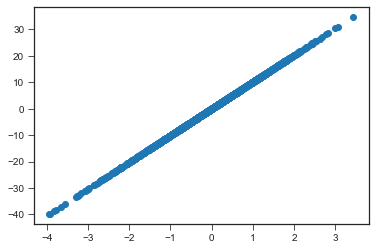

In [131]:
plt.scatter(pls.coef_, cca.coef_)

In [132]:
coefs = pd.DataFrame({'pls': pls.coef_[:, 0], 'cca': cca.coef_[:, 0]}, index=data.index)
display(coefs)
# coefs.to_csv(r'..\data\processed\PLS_CCA_coefficients.csv')

,pls,cca
i,,
l_0,1.315299,13.322491
l_1,1.036044,10.493948
l_2,0.220618,2.234608
l_3,-0.134158,-1.358870
l_4,0.087439,0.885663
...,...,...
m_169,-3.568107,-36.140882
m_213,-0.833284,-8.440222
m_24,-1.340800,-13.580786


In [107]:
pls.x_scores_.shape

(60, 20)

In [110]:
pls.predict(X_all)

array([[ 846.79139076],
       [ 846.72870009],
       [ 846.74373474],
       [ 993.0152532 ],
       [ 993.04815883],
       [ 993.07237432],
       [1761.77988734],
       [1761.69851686],
       [1761.67774109],
       [1648.81918916],
       [1648.80535111],
       [1648.72076514],
       [1350.245693  ],
       [1350.35066283],
       [1350.25858552],
       [1377.90803438],
       [1377.89210031],
       [1377.96677398],
       [1738.28566472],
       [1738.15436426],
       [1738.31602583],
       [2321.26275925],
       [2321.21605182],
       [2321.29861271],
       [2224.78612225],
       [2224.67184857],
       [2224.81803689],
       [2015.75279199],
       [2015.74926373],
       [2015.62653605],
       [ 846.70030477],
       [ 846.76229902],
       [ 846.79476615],
       [ 992.95633743],
       [ 992.99434746],
       [ 992.87615894],
       [1761.62317534],
       [1761.78557729],
       [1761.78027674],
       [1648.74512679],
       [1648.66008077],
       [1648.784

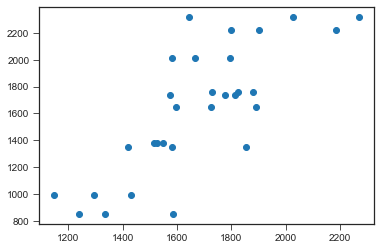

In [135]:
plt.scatter(pls.predict(X_all.loc[fbg_cols]), y_ogtt.loc[fbg_cols])
# plt.gcf().set_size_inches(10, 4)

In [73]:
pls.x_weights_.shape

(1727, 10)

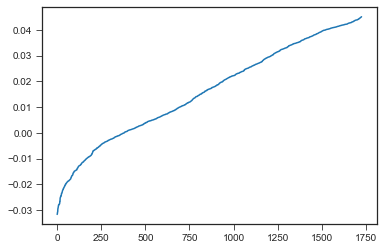

In [136]:
plt.plot(range(1727), np.sort(pls.x_loadings_[:, 0]))

In [95]:
pls.y_scores_.shape

(60, 10)

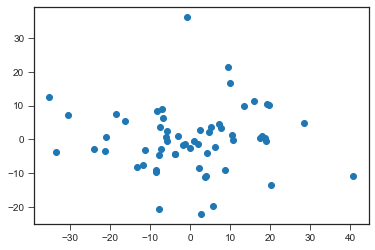

In [93]:
plt.scatter(pls.x_scores_[:, 0], pls.x_scores_[:, 1])

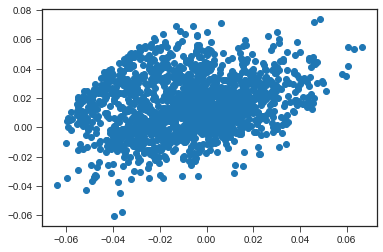

In [109]:
plt.scatter(pls.x_weights_[:, 0], pls.x_weights_[:, 1])

In [130]:
import numpy as np
import pylab as pl
from sklearn.decomposition import PLSCanonical, PLSRegression, CCA

###############################################################################
# Dataset based latent variables model

n = 500
# 2 latents vars:
l1 = np.random.normal(size=n)
l2 = np.random.normal(size=n)

latents = np.array([l1, l1, l2, l2]).T
X = latents + np.random.normal(size=4 * n).reshape((n, 4))
Y = latents + np.random.normal(size=4 * n).reshape((n, 4))

X_train = X[:n / 2]
Y_train = Y[:n / 2]
X_test = X[n / 2:]
Y_test = Y[n / 2:]

print("Corr(X)")
print(np.round(np.corrcoef(X.T), 2))
print("Corr(Y)")
print(np.round(np.corrcoef(Y.T), 2))

###############################################################################
# Canonical (symetric) PLS

# Transform data
# ~~~~~~~~~~~~~~
plsca = PLSCanonical(n_components=2)
plsca.fit(X_train, Y_train)
X_train_r, Y_train_r = plsca.transform(X_train, Y_train)
X_test_r, Y_test_r = plsca.transform(X_test, Y_test)

# Scatter plot of scores
# ~~~~~~~~~~~~~~~~~~~~~~
# 1) On diagonal plot X vs Y scores on each components
pl.figure(figsize=(12, 8))
pl.subplot(221)
pl.plot(X_train_r[:, 0], Y_train_r[:, 0], "ob", label="train")
pl.plot(X_test_r[:, 0], Y_test_r[:, 0], "or", label="test")
pl.xlabel("x scores")
pl.ylabel("y scores")
pl.title('Comp. 1: X vs Y (test corr = %.2f)' %
         np.corrcoef(X_test_r[:, 0], Y_test_r[:, 0])[0, 1])
pl.xticks(())
pl.yticks(())
pl.legend(loc="best")

pl.subplot(224)
pl.plot(X_train_r[:, 1], Y_train_r[:, 1], "ob", label="train")
pl.plot(X_test_r[:, 1], Y_test_r[:, 1], "or", label="test")
pl.xlabel("x scores")
pl.ylabel("y scores")
pl.title('Comp. 2: X vs Y (test corr = %.2f)' %
         np.corrcoef(X_test_r[:, 1], Y_test_r[:, 1])[0, 1])
pl.xticks(())
pl.yticks(())
pl.legend(loc="best")

# 2) Off diagonal plot components 1 vs 2 for X and Y
pl.subplot(222)
pl.plot(X_train_r[:, 0], X_train_r[:, 1], "*b", label="train")
pl.plot(X_test_r[:, 0], X_test_r[:, 1], "*r", label="test")
pl.xlabel("X comp. 1")
pl.ylabel("X comp. 2")
pl.title('X comp. 1 vs X comp. 2 (test corr = %.2f)' % \
    np.corrcoef(X_test_r[:, 0], X_test_r[:, 1])[0, 1])
pl.legend(loc="best")
pl.xticks(())
pl.yticks(())

pl.subplot(223)
pl.plot(Y_train_r[:, 0], Y_train_r[:, 1], "*b", label="train")
pl.plot(Y_test_r[:, 0], Y_test_r[:, 1], "*r", label="test")
pl.xlabel("Y comp. 1")
pl.ylabel("Y comp. 2")
pl.title('Y comp. 1 vs Y comp. 2 , (test corr = %.2f)' % \
    np.corrcoef(Y_test_r[:, 0], Y_test_r[:, 1])[0, 1])
pl.legend(loc="best")
pl.xticks(())
pl.yticks(())
pl.show()

###############################################################################
# PLS regression, with multivariate response, a.k.a. PLS2

n = 1000
q = 3
p = 10
X = np.random.normal(size=n * p).reshape((n, p))
B = np.array([[1, 2] + [0] * (p - 2)] * q).T
# each Yj = 1*X1 + 2*X2 + noize
Y = np.dot(X, B) + np.random.normal(size=n * q).reshape((n, q)) + 5

pls2 = PLSRegression(n_components=3)
pls2.fit(X, Y)
print("True B (such that: Y = XB + Err)")
print(B)
# compare pls2.coefs with B
print("Estimated B")
print(np.round(pls2.coefs, 1))
pls2.predict(X)

###############################################################################
# PLS regression, with univariate response, a.k.a. PLS1

n = 1000
p = 10
X = np.random.normal(size=n * p).reshape((n, p))
y = X[:, 0] + 2 * X[:, 1] + np.random.normal(size=n * 1) + 5
pls1 = PLSRegression(n_components=3)
pls1.fit(X, y)
# note that the number of compements exceeds 1 (the dimension of y)
print("Estimated betas")
print(np.round(pls1.coefs, 1))

###############################################################################
# CCA (PLS mode B with symetric deflation)

cca = CCA(n_components=2)
cca.fit(X_train, Y_train)
X_train_r, Y_train_r = plsca.transform(X_train, Y_train)
X_test_r, Y_test_r = plsca.transform(X_test, Y_test)

ImportError: cannot import name 'PLSCanonical' from 'sklearn.decomposition' (C:\Users\bjanderson23\anaconda3\lib\site-packages\sklearn\decomposition\__init__.py)